# Data Visualization

Velocity map size: (500, 1, 70, 70)
Seismic data size: (500, 5, 1000, 70)


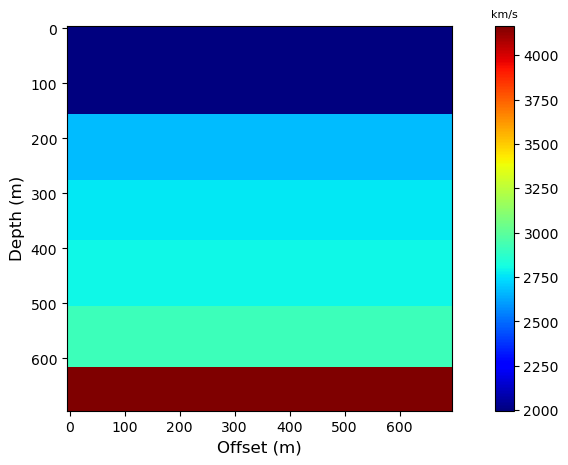

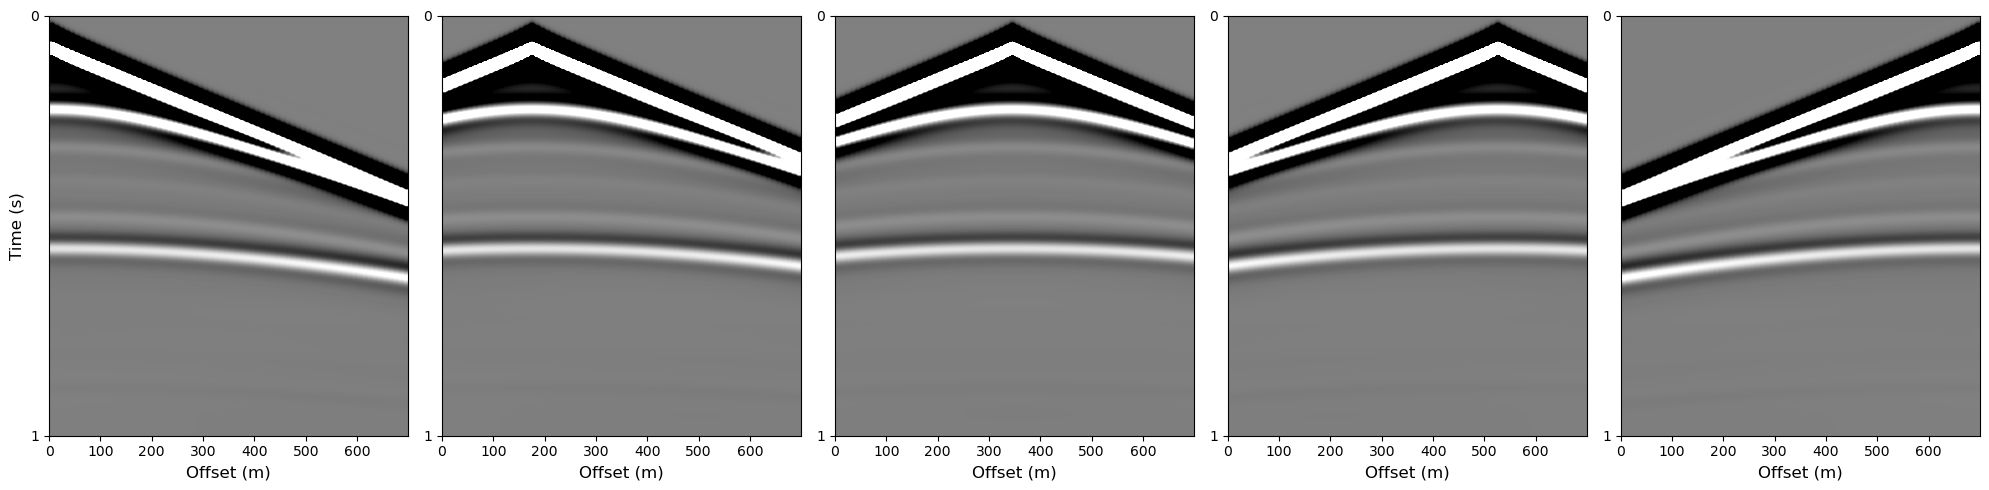

In [4]:
%run data_loading.py

Epoch 1/5: 100%|██████████| 200/200 [00:20<00:00,  9.62it/s]


Epoch [1/5] Train MAE: 553.3036 Val MAE: 416.1949


Epoch 2/5: 100%|██████████| 200/200 [00:15<00:00, 12.67it/s]


Epoch [2/5] Train MAE: 364.8735 Val MAE: 359.5476


Epoch 3/5: 100%|██████████| 200/200 [00:15<00:00, 12.66it/s]


Epoch [3/5] Train MAE: 333.3227 Val MAE: 339.2687


Epoch 4/5: 100%|██████████| 200/200 [00:14<00:00, 13.68it/s]


Epoch [4/5] Train MAE: 323.5954 Val MAE: 315.2762


Epoch 5/5: 100%|██████████| 200/200 [00:15<00:00, 13.07it/s]


Epoch [5/5] Train MAE: 316.3348 Val MAE: 297.4300


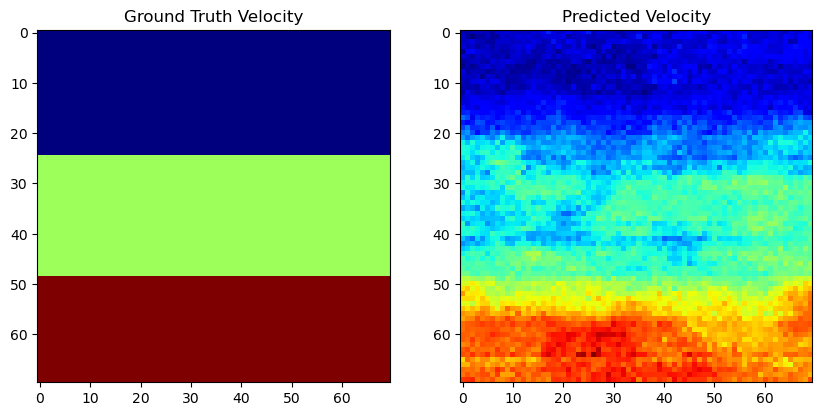

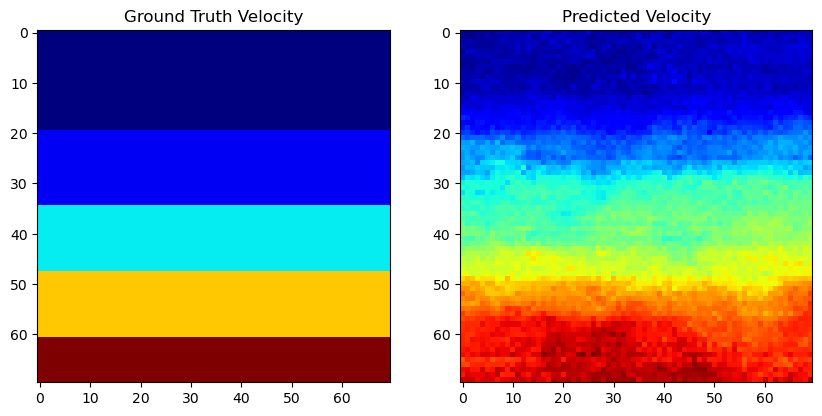

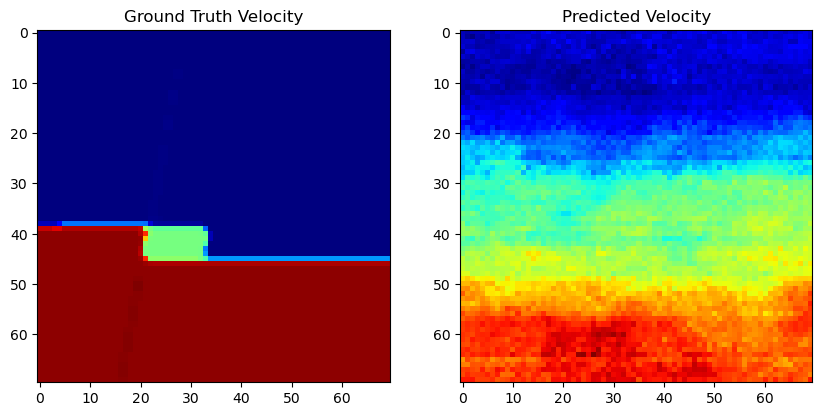

In [2]:
%run training_example.py

In [3]:
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Feature Engineering

In [4]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [154]:
class SeismicDataset(Dataset):
    def __init__(self, data_pairs):
        self.data = []
        self.targets = []
        
        for seismic_path, velocity_path in data_pairs:
            seismic = np.load(seismic_path)
            velocity = np.load(velocity_path)
            
            B, S, T, R = seismic.shape

            # Normalize
            #seismic_flat = seismic.reshape(B, -1)
            #seismic_mean = seismic_flat.mean(axis = 1, keepdims = True)
            #seismic_std = seismic_flat.std(axis = 1, keepdims = True)
            #seismic_norm = (seismic_flat - seismic_mean) / seismic_std

            # Reshape to grid
            #seismic_grid = seismic.reshape(B, S*T, 1, R)

            #B, _, H, W = velocity.shape

            # Normalize
            #velocity_flat = velocity.reshape(B, -1)
            #velocity_mean = velocity_flat.mean()
            #velocity_std = velocity_flat.std()
            #velocity_norm = (velocity_flat - velocity_mean) / velocity_std

            # Return to original shape
            #velocity = velocity.reshape(B, 1, H, W)
            
            self.data.append(torch.from_numpy(seismic).float())
            self.targets.append(torch.from_numpy(velocity).float())

        self.data = torch.cat(self.data, dim=0)
        self.targets = torch.cat(self.targets, dim=0)

        print("Input Shape: ", self.data.shape, "Target Shape: ", self.targets.shape)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x, y

In [218]:
data_pairs = [
    ('FlatVel_A/data/data1.npy', 'FlatVel_A/model/model1.npy'),
    ('CurveFault_A/seis2_1_0.npy', 'CurveFault_A/vel2_1_0.npy'),
    ('FlatFault_A/seis2_1_0.npy', 'FlatFault_A/vel2_1_0.npy'),
    ('Style_A/data/data1.npy', 'Style_A/model/model1.npy')
]

batch_size = 10

dataset = SeismicDataset(data_pairs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Split into train and validation
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = int(0.1 * len(dataset))
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Input Shape:  torch.Size([2000, 5, 1000, 70]) Target Shape:  torch.Size([2000, 1, 70, 70])


# Model

In [229]:
def get_grid(batchsize, size_x, size_y, device):
    gridx = torch.linspace(0, 1, size_x, device=device)
    gridy = torch.linspace(0, 1, size_y, device=device)
    gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
    gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
    return torch.cat((gridx, gridy), dim=1)

In [230]:
class SpectralConv(nn.Module):
    def __init__(self, in_channels, out_channels, modes_x, modes_y):
        super(SpectralConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes_x = modes_x
        self.modes_y = modes_y

        self.scale = 1 / (self.in_channels*self.out_channels)
        #self.weights_amplitude = nn.Parameter(self.scale*torch.rand(self.in_channels, self.out_channels, self.modes_x, self.modes_y))
        #self.weights_phase = nn.Parameter(self.scale*torch.rand(self.in_channels, self.out_channels, self.modes_x, self.modes_y))
        self.weights = nn.Parameter(self.scale * torch.randn(in_channels+2, out_channels, modes_x, modes_y, 2))
        
    def forward(self, x):
        batchsize, channels, h, w = x.shape

        weights_cplx = torch.complex(self.weights[..., 0], self.weights[..., 1])
        out_fourier = torch.fft.rfft2(x, norm='ortho')
        out_cropped = out_fourier[:, :, :self.modes_x, :self.modes_y]
        
        out = torch.zeros(batchsize, self.out_channels, h, w // 2 + 1, dtype=torch.cfloat, device=device)
        out[:, :, :self.modes_x, :self.modes_y] = torch.einsum("bixy, ikxy -> bkxy", out_cropped, weights_cplx)
   
        # Perform's the IFFT
        out = torch.fft.irfft2(out, s=(h, w), norm='ortho')

        return out

In [231]:
class FNO(nn.Module):
    def __init__(self, modes_x, modes_y, width, num_layers, input_size, output_size, activation_func):
        super(FNO, self).__init__()

        self.num_layers = num_layers
        self.lift = nn.Conv2d(input_size+2, width, kernel_size=1)
        self.projection = nn.Conv2d(width+2, output_size, kernel_size=1)
        self.spectrals = nn.ModuleList([SpectralConv(width, width+2, modes_x, modes_y) for i in range(num_layers)])
        self.convs = nn.ModuleList([nn.Conv2d(width+2, width+2, kernel_size=1) for i in range(num_layers)])
        self.activation_func = activation_func

        self.encoder = nn.Sequential(
            nn.Conv2d(5, 32, kernel_size=3, padding=1),  # (B, 32, 1000, 70)
            nn.GELU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (B, 64, 1000, 70)
            nn.GELU(),
            nn.AdaptiveAvgPool2d((70, 70)),              # (B, 64, 70, 70)
            nn.Conv2d(64, width, kernel_size=1)          # (B, width, 70, 70)
        )

    def forward(self, x):
        x = self.encoder(x)
        batchsize, _, h, w = x.shape
        grid = get_grid(batch_size, h, w, device)
        x = torch.cat((x, grid), dim=1)
        
        #x_upsampled = F.interpolate(x, size=(70, 70), mode='bilinear', align_corners=False)
        x_lifted = self.lift(x)

        spec_out = self.spectrals[0](x).to(device)
        conv_out = self.convs[0](x).to(device)
        activ = self.activation_func(spec_out + conv_out)
        
        for i in range(1, self.num_layers - 1):
            spec_out = self.spectrals[i](activ)
            conv_out = self.convs[i](activ)
            activ = self.activation_func(spec_out.to(device) + conv_out.to(device))

        out = self.projection(activ)
        out = F.interpolate(out, size=(70, 70), mode='bilinear', align_corners=False)

        return out

# Training

In [232]:
learning_rate = 5e-3
epochs = 250

In [ ]:
val_loss_arr = []
train_loss_arr = []

model = FNO(32, 32, 64, 4, 64, 1, nn.GELU()).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = torch.nn.L1Loss()

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        train_loss_arr.append(train_loss)
    
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            val_loss_arr.append(val_loss)
    
    val_loss /= len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{epochs}] Train MAE: {train_loss:.4f} Val MAE: {val_loss:.4f}")

In [ ]:
torch.save(model.state_dict(), "model")

# Visualize

In [224]:
model = FNO(32, 32, 64, 4, 64, 1, nn.GELU()).to(device)
model.load_state_dict(torch.load('model_mae111'))

<All keys matched successfully>

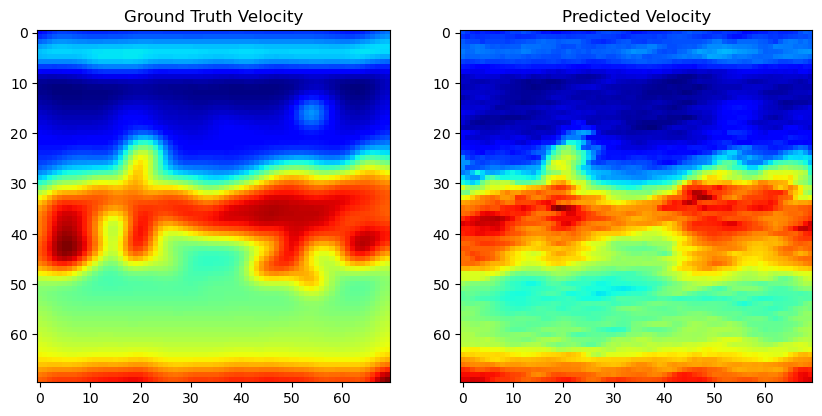

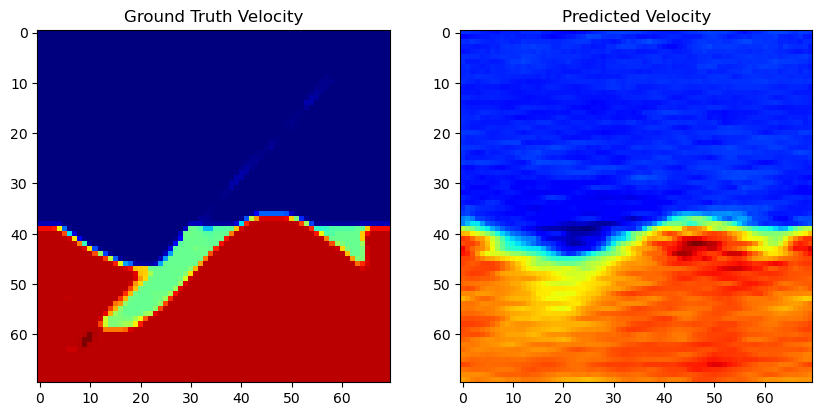

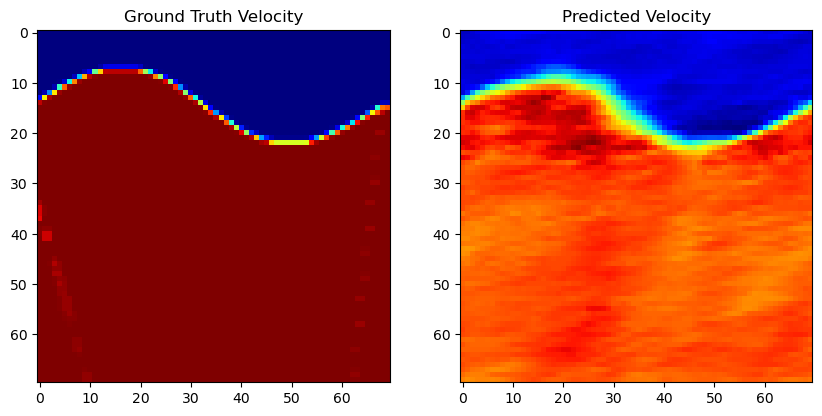

In [225]:
model.eval()
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
with torch.no_grad():
    predictions = model(inputs)

for i in range(min(3, inputs.size(0))):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(targets[i][0].cpu(), cmap='jet')
    axs[0].set_title('Ground Truth Velocity')
    axs[1].imshow(predictions[i][0].cpu(), cmap='jet')
    axs[1].set_title('Predicted Velocity')
    plt.show()

# Evaluation

In [228]:
from torchmetrics.functional import structural_similarity_index_measure as ssim_fn

mae_loss_arr = []
rmse_loss_arr = []
ssim_loss_arr = []
rel_l2_arr = []

mae_loss = 0.0
rmse_loss = 0.0
ssim_loss = 0.0
rel_l2_loss = 0.0

mae_crit = torch.nn.L1Loss()
mse_crit = torch.nn.MSELoss()

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)

        loss = mae_crit(outputs, targets)
        mae_loss += loss.item() * inputs.size(0)
        mae_loss_arr.append(mae_loss)

        loss = mse_crit(outputs, targets)
        rmse_loss += torch.sqrt(loss).item() * inputs.size(0)
        rmse_loss_arr.append(rmse_loss)

        loss = 1 - ssim_fn((outputs + 1) / 2, (targets + 1) / 2, data_range=1.0)
        ssim_loss += loss.item() * inputs.size(0)
        ssim_loss_arr.append(ssim_loss)

        loss = torch.linalg.norm(outputs - targets) / torch.linalg.norm(targets)
        rel_l2_loss += loss.item() * inputs.size(0)
        rel_l2_arr.append(rel_l2_loss)
    
    mae_loss /= len(test_loader.dataset)
    rmse_loss /= len(test_loader.dataset)
    ssim_loss /= len(test_loader.dataset)
    rel_l2_loss /= len(test_loader.dataset)

    print("MAE Loss: ", mae_loss)
    print("RMSE Loss: ", rmse_loss)
    print("SSIM Loss: ", ssim_loss)
    print("Rel L2 Loss: ", rel_l2_loss)

MAE Loss:  106.92269515991211
RMSE Loss:  166.74329071044923
SSIM Loss:  0.7273962289094925
Rel L2 Loss:  0.05605310760438442
